 # 毕业设计

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR


 ## 获取数据

In [ ]:
path = '../../../Dataset/Stock/'
freq_dict = {
    'day': 'B',
    'week': '7D',
    'month': 'BM'
}
offset_dict = {
    'day': pd.offsets.BDay(),
    'week': pd.offsets.Week(),
    'month': pd.offsets.BusinessMonthEnd()
}


In [ ]:


def get_data(frequency: str, T: str) -> None:
    data_path = os.path.join(path, frequency)
    data_1 = pd.read_csv('Data/test.csv')  # 空文件，迭代用
    freq = freq_dict[frequency]
    offset = offset_dict[frequency]

    for file in os.listdir(data_path):
        df = pd.read_csv(os.path.join(data_path, file), index_col='index', parse_dates=True)  # 以时间序列为索引
        df.dropna(inplace=True)  # 去除空值

        up = df.query('open<close')  # 阳线
        down = df.query('open>close')  # 阴线
        up = up.tshift(1, freq=freq)  # 将阳线时间戳后移

        new = up.join(down, how='inner', lsuffix='_up', rsuffix='_down')  # 合并
        new.query('vol_down>vol_up', inplace=True)  # vol(2)>vol(1)

        # close(2)>close(1)
        first = new.query('close_down>close_up')
        low_mean = pd.Series(index=first.index, name='T_mean')
        for start in first.index:
            period = pd.date_range(start=start + offset, periods=int(T), freq=freq)
            # 时间范围可能无效
            try:
                low_mean[start] = df.loc[period].low.mean()
            except:
                first.drop(index=start, inplace=True)  # 清除无效行
                continue
        low_mean = pd.Series(low_mean, index=first.index, name='T_mean')
        code = pd.Series(np.repeat(file, first.shape[0]), index=first.index, name='code')
        piece = pd.concat([first, low_mean, code], axis=1, join='inner')
        data_1 = pd.concat([data_1, piece])

    # close(2)>close(1) & low(2)<low(1)
    data_2 = data_1.query('low_down<low_up')

    data_1.to_csv(os.path.join('Data', 'T=' + T, frequency + '_1.csv'))
    data_2.to_csv(os.path.join('Data', 'T=' + T, frequency + '_2.csv'))



In [ ]:
for T in np.arange(2, 16).astype(np.str):
    for frequency in ['day', 'week']:  # month数据量太少，无意义
        get_data(frequency, T)


 ## 构建模型

In [19]:
path = 'Data/'


In [20]:


def del_outliers(df: pd.DataFrame) -> pd.DataFrame:  # Tukey Method
    q1 = df['T_mean'].quantile(0.25)
    q3 = df['T_mean'].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.3 * iqr
    high = q3 + 1.3 * iqr
    return df[(df['T_mean'] > low) & (df['T_mean'] < high)]


In [41]:


def training_with_all(state: str, T_range: np.ndarray, param: dict) -> pd.DataFrame:
    result = pd.DataFrame(columns=['mse', 'gamma', 'C'], index=T_range)

    print(state, ' begin.')

    for T in T_range:
        data_path = os.path.join(path, 'T=' + T, state + '.csv')
        df = pd.read_csv(data_path).drop(columns=['code', 'Unnamed: 0'])

        new = del_outliers(df)

        X = new.drop(columns='T_mean')
        y = new['T_mean']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 分割
        std_scaler = StandardScaler()  # 标准化
        X_train = std_scaler.fit_transform(X_train)
        X_test = std_scaler.transform(X_test)

        '''
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        randomcv = RandomizedSearchCV(SVR(kernel='rbf'), param_distributions=param,
                                      scoring='neg_mean_squared_error', n_jobs=-1, cv=cv, random_state=42, verbose=2)
        randomcv.fit(X_train, y_train)

        y_pred = randomcv.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        result['mse'][T] = mse
        result['gamma'][T] = randomcv.best_estimator_.gamma
        result['C'][T] = randomcv.best_estimator_.C

        print('T=' + T + ': complete.', 'mse=', mse, ', param=', randomcv.best_param)
        '''

        def hyperopt_train_test(kwargs):
            reg = SVR(kernel='rbf', **kwargs)
            cv = KFold(n_splits=5, shuffle=True, random_state=42)
            return cross_val_score(reg, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1).mean()

        def f(kwargs):
            nmse = hyperopt_train_test(kwargs)
            return {'loss': -nmse, 'status': STATUS_OK}

        space4svr = param
        best = fmin(f, space4svr, algo=tpe.suggest, max_evals=200, rstate=np.random.RandomState(42)) # max_evals=100 for day_1

        best_estimator = SVR(kernel='rbf', **best)
        best_estimator.fit(X_train, y_train)
        y_pred = best_estimator.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        result['mse'][T] = mse
        result['gamma'][T] = best_estimator.gamma
        result['C'][T] = best_estimator.C

    print(state, ' complete.')

    return result



In [43]:
T_range = np.arange(2, 16).astype(np.str)
space = {
    'C': hp.uniform('C', 1, 1000),
    'gamma': hp.uniform('gamma', 0.00001, 0.1)
}
for state in ['day_2']:
    result = training_with_all(state=state, T_range=T_range, param=space)
    result.to_csv('result_' + state + '.csv', index_label='T')


day_2  begin.
100%|██████████| 200/200 [00:32<00:00,  6.18trial/s, best loss: 0.9027671500212581]
day_2  complete.


 ### 测试

In [ ]:
T_range = np.arange(2, 16).astype(np.str)
space = {
    'C': hp.uniform('C', 1, 1000),
    'gamma': hp.uniform('gamma', 0.0001, 0.1)
}
state='day_1'
test = training_with_all(state=state, T_range=T_range, param=space)
test.to_csv('result_' + state + '.csv', index_label='T')


In [ ]:
df = pd.read_csv('result_' + state + '.csv', index_col='T')
df

In [ ]:
fig = px.scatter_3d(
    df,
    x=df.index,
    y='gamma',
    z='C',
    size='mse',
    log_y=True,
    title=state,
    width=600,
    height=600
)
fig.show()

 ## 结论

 ### 图表

In [3]:
day_1 = pd.concat([pd.read_csv('result_day_1.csv'), pd.Series(np.repeat('日线_1',14), name='state')], axis=1)
day_2 = pd.concat([pd.read_csv('result_day_2.csv'), pd.Series(np.repeat('日线_2',14), name='state')], axis=1)
week_1 = pd.concat([pd.read_csv('result_week_1.csv'), pd.Series(np.repeat('周线_1',14), name='state')], axis=1)
week_2 = pd.concat([pd.read_csv('result_week_2.csv'), pd.Series(np.repeat('周线_2',14), name='state')], axis=1)
result = pd.concat([day_1, day_2, week_1, week_2], ignore_index=True)

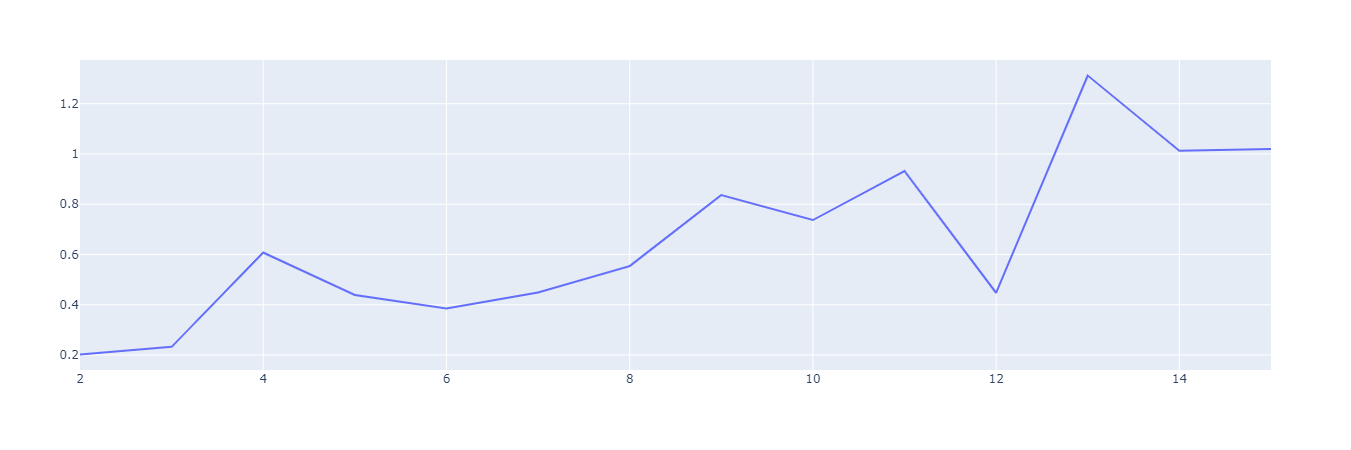

In [45]:
fig = px.line(
    day_2,
    x='T',
    y='mse',
    labels={
        'T':'$T$',
        'mse':'$MSE$'
    }
)
fig.show()

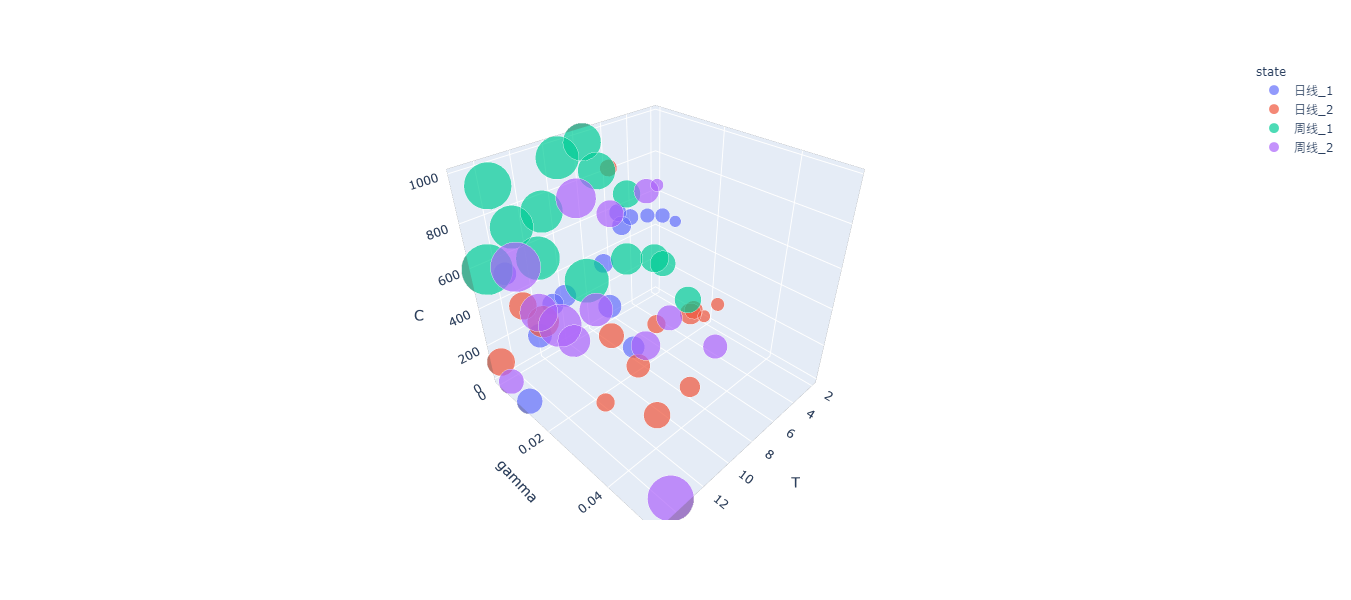

In [47]:
fig = px.scatter_3d(
    result,
    x='T',
    y='gamma',
    z='C',
    size='mse',
    color='state',
    size_max=40,
    width=600,
    height=600
)
fig.show()

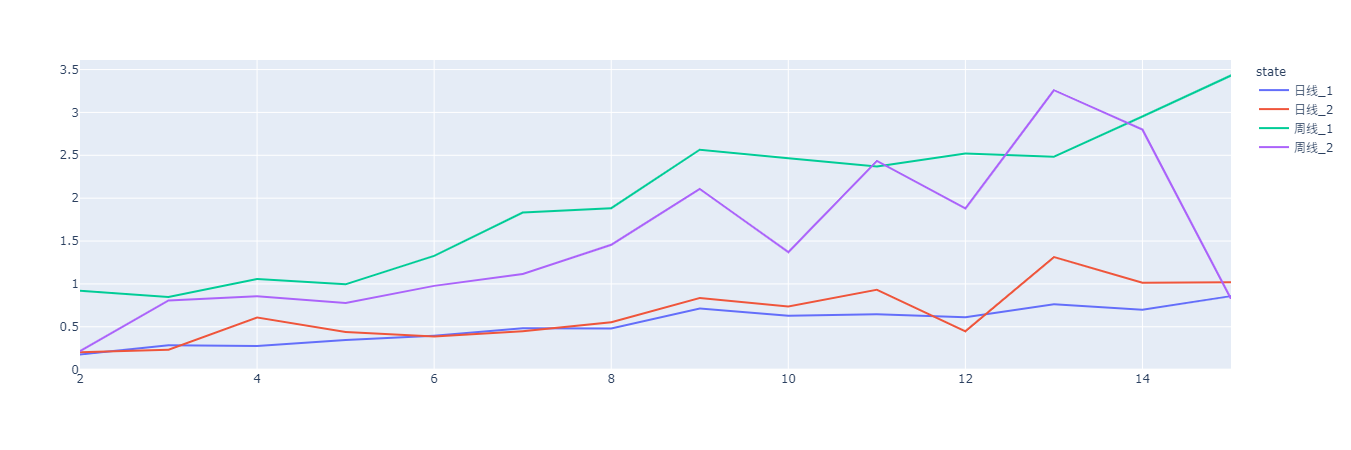

In [46]:
fig = px.line(
    result,
    x='T',
    y='mse',
    color='state',
    labels={
        'T':'$T$',
        'mse':'$MSE$'
    }
)
fig.show()

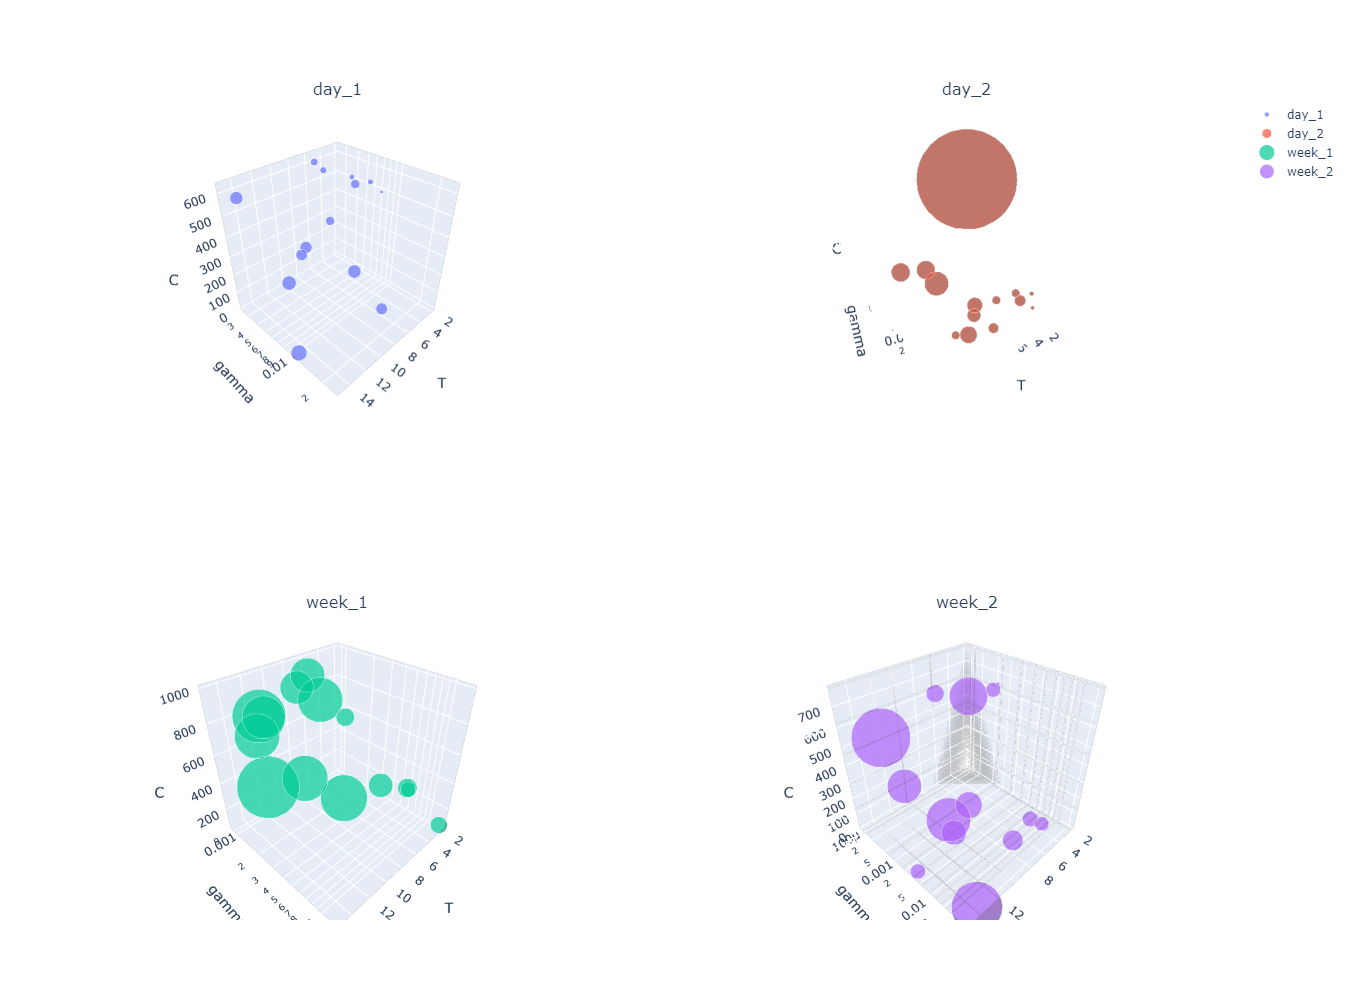

In [13]:
fig = make_subplots(
    rows=2,
    cols=2,
    specs=[
        [{'type': 'scene'}, {'type': 'scene'}],
        [{'type': 'scene'}, {'type': 'scene'}]
    ],
    subplot_titles=['day_1', 'day_2', 'week_1', 'week_2']
)
fig.add_traces(
    [go.Scatter3d(
        x=df['T'],
        y=df['gamma'],
        z=df['C'],
        mode='markers',
        marker_size=df['mse'] * 10,
        name=name,
        text=df['mse'],
        hovertemplate='T=%{x}<br>gamma=%{y}<br>C=%{z}<br>mse=%{text}'
    ) for df, name in [(day_1, 'day_1'), (day_2, 'day_2'), (week_1, 'week_1'), (week_2, 'week_2')]],
    rows=[1, 1, 2, 2],
    cols=[1, 2, 1, 2]
)
scene_dict = dict(
    xaxis_title='T',
    yaxis=dict(
        type='log',
        title='gamma'
    ),
    zaxis_title='C',
)
fig.update_layout(
    scene=scene_dict,
    scene2=scene_dict,
    scene3=scene_dict,
    scene4=scene_dict,
    width=1000,
    height=1000
)
fig.show()


In [7]:
print(week_2.to_latex(columns=['T','mse','gamma','C'],index=False))

\begin{tabular}{rrrr}
\toprule
  T &       mse &     gamma &           C \\
\midrule
  2 &  0.217053 &  0.000597 &  645.037239 \\
  3 &  0.807187 &  0.000706 &  638.891066 \\
  4 &  0.854804 &  0.013319 &   35.447789 \\
  5 &  0.777241 &  0.032458 &  110.625151 \\
  6 &  0.977071 &  0.000089 &  596.074655 \\
  7 &  1.116184 &  0.016363 &   21.808967 \\
  8 &  1.456059 &  0.001896 &  133.605112 \\
  9 &  2.108794 &  0.002949 &  771.465479 \\
 10 &  1.370244 &  0.002010 &   23.700295 \\
 11 &  2.433986 &  0.002540 &  169.902368 \\
 12 &  1.879384 &  0.000298 &  263.846302 \\
 13 &  3.259515 &  0.000190 &  543.159172 \\
 14 &  2.799411 &  0.051765 &   32.916058 \\
 15 &  0.825082 &  0.003597 &   31.110291 \\
\bottomrule
\end{tabular}

